# Linear Regression Notes

This note is to remind myself about some of the basic concepts of linear regression.

**Bibliography**

[1] James, Witten, Hastie, Tibshirani - Introduction to Statistical Learning

## Setup

In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pylab as plt

In [2]:
%matplotlib inline

In [3]:
(blue, orange, red, green, purple, brown, pink, yellow, lightred, lightblue,
lightorange, lightgreen, lightpurple) = \
('#377eb8', '#ff7f00', '#e41a1c', '#4daf4a', '#984ea3', '#a65628', '#f781bf',
'#d2d215', '#fb9a99', '#a6cee3', '#fdbf6f', '#b2df8a', '#cab2d6')

## Creating some (noisy) toy data

In [4]:
def create_data(b0, b1, noise_sd, n=100):
    """Return a dataframe with `n` rows and columns 'X' and 'Y'
    The dataframe will contain random data points that follow
    ``Y = b1 * X + b0 + eps`` where the error `eps` is drawn from
    a normal distribution with standard deviation `noise_sd`
    """
    x = np.sort(10 * np.random.rand(n))
    y = b1 * x + b0
    noise = scipy.stats.norm(scale=noise_sd)
    y += noise.rvs(len(x))
    return pd.DataFrame({'X': x, 'Y': y})

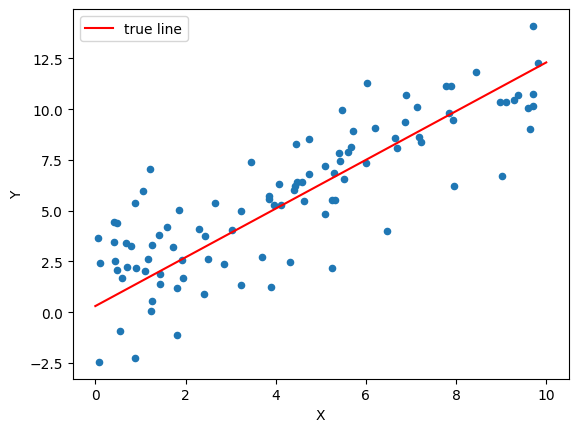

In [5]:
b0_true = 0.3
b1_true = 1.2
noise_sd = 2.0  # σ in the standard distribution

data = create_data(b0_true, b1_true, noise_sd)

def plot_data(data, *lines, show=True, **kwargs):
    fig, ax = plt.subplots(**kwargs)
    data.plot.scatter('X', 'Y', ax=ax)
    for (b0, b1, label, color) in lines:
        ax.plot(
            np.linspace(0, 10, 5),
            b0 + np.linspace(0, 10, 5) * b1,
            color=color, label=label)
    ax.legend()
    if show:
        plt.show(fig)
    else:
        return fig, ax
    
plot_data(data, (b0_true, b1_true, 'true line', 'red'))

## Linear Regression with statsmodels

In [6]:
import statsmodels.api as sm

In [7]:
mod = sm.OLS(data['Y'], sm.add_constant(data['X']))

In [8]:
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     228.0
Date:                Sun, 22 Jan 2023   Prob (F-statistic):           2.55e-27
Time:                        12:08:04   Log-Likelihood:                -207.72
No. Observations:                 100   AIC:                             419.4
Df Residuals:                      98   BIC:                             424.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3407      0.346      3.876      0.000       0.654       2.027
X              1.0144      0.067     15.098      0.000       0.881       1.148
==============================================================================
Omnibus:                        2.898   Durbin-Watson:                   2.206
Prob(Omnibus):                  0.235   Jarque-Bera (JB):                2.676
Skew:                          -0.400   Prob(JB):                        0.262
Kurtosis:                       2.960   Cond. No.                         9.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
res.params

const    1.340737
X        1.014445
dtype: float64

## Manual Linear Regression

In [10]:
def linear_regression(data):
    """Estimated b0_hat, b1_hat for the given data.

    See [1] Eq. (3.4)
    """
    xbar = data['X'].mean()
    ybar = data['Y'].mean()
    delta_x = data['X'] - xbar
    delta_y = data['Y'] - ybar
    b1_hat = np.dot(delta_x, delta_y) / np.dot(delta_x, delta_x)
    b0_hat = ybar - b1_hat * xbar
    return b0_hat, b1_hat

In [11]:
b0_hat, b1_hat = linear_regression(data)

In [12]:
b0_hat, b1_hat

(1.3407370728448775, 1.0144446957055053)

In [13]:
b0_true, b1_true

(0.3, 1.2)

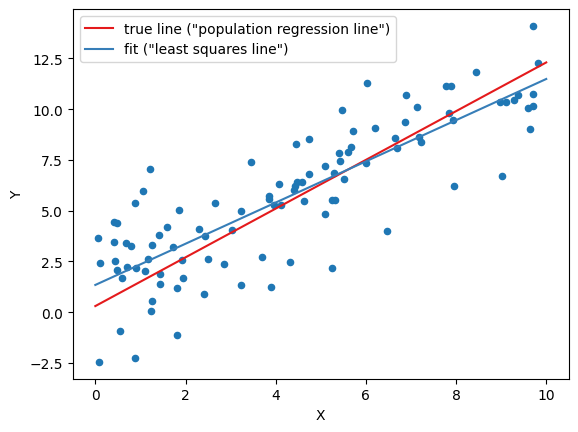

In [14]:
plot_data(
    data,
    (b0_true, b1_true, 'true line ("population regression line")', red),
    (b0_hat, b1_hat, 'fit ("least squares line")', blue)
)

## Goodness of Fit

### Standard Error

The Standard Error describes how close an estimated quantity is expected to be to the actual quantity.

It is the standard deviation of the "sampling distribution" of a statistical quantity: If you take a large number of independent samples, each of size $n$, and calculate the statistical quantity for each sample individually, then the standard errror is the standard deviation of the distribution of those results. It is always $\sigma/\sqrt{n}$, where $\sigma$ is the (possibly unknown) standard deviation of the original distribution. Standard errors go to zero as sample sizes go to infinity; standard deviations do not.

In [15]:
def residuals(data, b0, b1):
    """Array of residuals from the perfect linear relation ``Y=b1*X+b0``"""
    Y_hat = b1 * data['X'] + b0
    return data['Y'] - Y_hat

In [16]:
def RSS(data, b0, b1):
    """Residual Sum of Squares
    
    How much the Y values vary around the predicted Y values 
    """
    return (residuals(data, b0, b1)**2).sum()

In [17]:
def TSS(data):
    """Total Sum of Squares
   
    How much the Y values vary around the mean Y value
    """
    return ((data['Y'] - data['Y'].mean())**2).sum()

In [18]:
def RSE(data, b0, b1):
    """Residual standard error
    
    This is an estimate for the standard deviation σ of the true
    distribution (noise_sd). The y-values in the sample deviate from the 
    from the true regression line by about RSE units on average.
    """
    return np.sqrt(RSS(data, b0, b1) / (len(data)-2))

In [19]:
RSS(data, b0_hat, b1_hat)

373.07675962480016

In [20]:
RSE(data, b0_hat, b1_hat)

1.9511293423187364

In [21]:
noise_sd

2.0

In [22]:
def linear_regression_SE(data, sig):
    """Calculate the standard error for the estimate of b0, b1 in a
    linear regression for the given data, assuming a standard deviation of
    `sig` for the distribution of noise on Y. As `sig` is generally not known,
    it should be estimated by the RSE.
    
    Note that the standard error is a property of the sampling only:
    The `Y`-values do not enter!
    
    See [1] Eq. (3.8)
    """
    n = len(data)
    xbar = data['X'].mean()
    delta_x = data['X'] - xbar
    denom = np.dot(delta_x, delta_x)
    se_b0_sq = sig**2 * (1.0 / n + xbar**2/denom)
    se_b1_sq = sig**2 / denom
    return np.sqrt(se_b0_sq), np.sqrt(se_b1_sq)

In [23]:
linear_regression_SE(data, RSE(data, b0_hat, b1_hat))

(0.34590880729195916, 0.06718913728836097)

The 95% confidence intervals is $\pm$ two standard errors (probability that the true value is in the range of the confidence interval)

### Confidence Interval plot

See https://stats.stackexchange.com/questions/85560/shape-of-confidence-interval-for-predicted-values-in-linear-regression/85565#85565m for the full explanation and derivation.

In [24]:
def regline_SE(data, sig, xgrid):
    """The standard error of the full regression line, assuming 
    a standard deviation of `sig` for the distribution of noise on Y. As
    `sig` is generally not known, it should be estimated by the RSE.
    """
    n = len(data)
    return sig * np.sqrt(
        (1.0 / n) + (
            (xgrid - data['X'].mean())**2 /
            ((data['X'] - data['X'].mean())**2).sum()))

The 95% confidence band can be calculated as:

In [25]:
def regline_confidence_bands(data, b0_hat, b1_hat, xgrid, confidence=0.95):
    """Return two lines (arrays of y-values), the lower and upper boundary
    of the confidence band"""
    Y_hat = b0_hat + b1_hat * xgrid  # the fitted line, on the given xgrid
    n = len(data)
    sig = RSE(data, b0_hat, b1_hat)
    se = regline_SE(data, sig, xgrid)
    t_minus, t_plus = scipy.stats.t(df=n-2).interval(confidence)
    return Y_hat + t_minus * se, Y_hat + t_plus * se

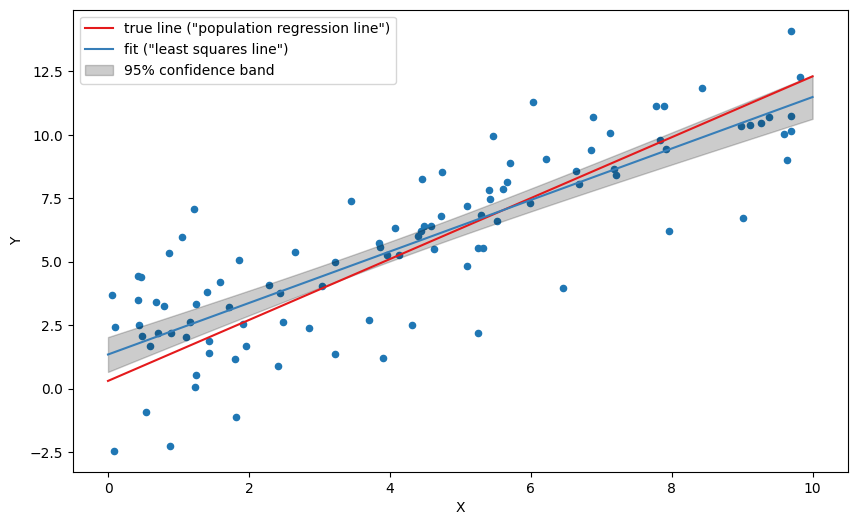

In [26]:
fig, ax = plot_data(
    data,
    (b0_true, b1_true, 'true line ("population regression line")', red),
    (b0_hat, b1_hat, 'fit ("least squares line")', blue),
    show=False, figsize=(10, 6)
)
xgrid = np.linspace(0, 10, 100)
lm, lp = regline_confidence_bands(data, b0_hat, b1_hat, xgrid)
ax.fill_between(
    xgrid, lm, lp,
    color='black', alpha=0.2, label='95% confidence band')
ax.legend()
plt.show(fig)

The confidence band should be interpreted as follows: There is a 95% probability that a fit based on any given sampling of the same distribution will land in the interval.

### Testing the null hypothesis

The null-hypthesis is that Y and X have no reltionship, i.e. b1 = 0. The $t$-value is the b1 in units of the standard error:

In [27]:
t = b1_hat / linear_regression_SE(data, RSE(data, b0_hat, b1_hat))[1]
t

15.09834381935479

The $t$-value follows a student distribution, and we can calculate a p-value (probability that $t$ has the given value, instead of 0)

In [28]:
2 * scipy.stats.t(df=len(data)-2).sf(t)  # = 1 - (cdf(t) - cdf(-t))

2.5471330315828787e-27

### The $R^2$ statistic

In [29]:
def R_sq(data, b0, b1):
    """R^2 in [0, 1] measures how well the variation in Y around the mean
    matches the variation in Y around the predicted value.
    
    That is, how much of the variability can be explained by the sampling"""
    return 1 - RSS(data, b0, b1) / TSS(data)

In [30]:
R_sq(data, b0_hat, b1_hat)

0.6993496006172107

A value close to 1 means that the linear fit is very good

### Normality of the residuals

A graphical way to check that the residuals are normal-distributed is to plot the quantiles of the residules against the quantiles of a normal distribution,
see https://stats.stackexchange.com/questions/321061/probability-that-residuals-are-normal/321071#321071

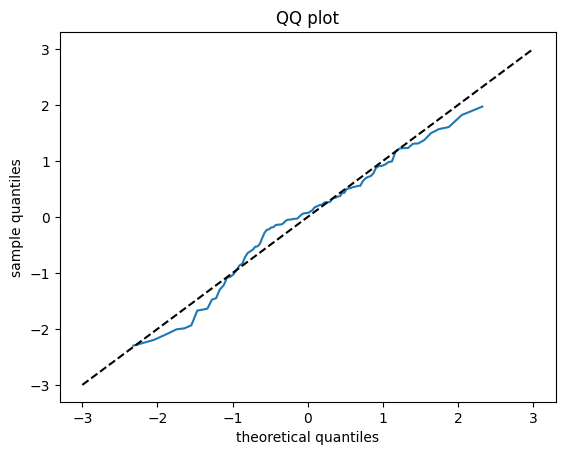

In [31]:
fig, ax = plt.subplots()
ax.plot(
    scipy.stats.norm().ppf(np.linspace(0, 1, len(data))),
    residuals(data, b0_hat, b1_hat).sort_values() / RSE(data, b0_hat, b1_hat))
ax.set_title('QQ plot')
ax.plot(
    np.linspace(-3, 3, 10), np.linspace(-3, 3, 10), color='black',
    ls='dashed')
ax.set_xlabel('theoretical quantiles')
ax.set_ylabel('sample quantiles')
plt.show(fig)

## Fit with known slope

In [32]:
b0_known_slope = np.mean(data['Y'] - b1_true*data['X'])

In [33]:
b0_known_slope

0.5519198289545456

In [34]:
b0_true

0.3

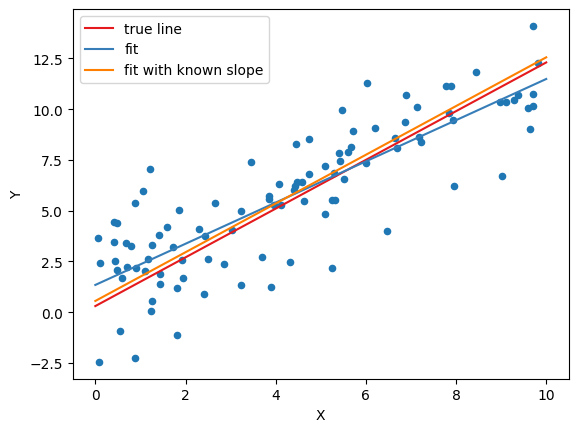

In [35]:
plot_data(
    data,
    (b0_true, b1_true, 'true line', red),
    (b0_hat, b1_hat, 'fit', blue),
    (b0_known_slope, b1_true, 'fit with known slope', orange),
    show=True,
)